## Interpretable forecasting with N-Beats

In [1]:
%load_ext lab_black

In [2]:
import os
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

In [4]:
pl.__version__

'1.4.9'

## Load data
We generate a synthetic dataset to demonstrate the network's capabilities. The data consists of a quadratic trend and a seasonality component.

In [5]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [6]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(
    training, data, min_prediction_idx=training_cutoff + 1
)
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

## Calculate baseline error

In [7]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.5462)

## Train network

In [8]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.01)
net = NBeats.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=0.1,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


/tmp/Python/python-3.9.6/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:817: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.851     Total estimated model params size (MB)
Global seed set to 42
Finding best initial lr: 100%|██████████| 100/100 [01:11<00:00,  1.17s/it]Restoring states from the checkpoint file at /work/notebooks/PyTorch-Forecasting/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /work/notebooks/PyTorch-Forecasting/lr_find_temp_model.ckpt


suggested learning rate: 0.004466835921509632


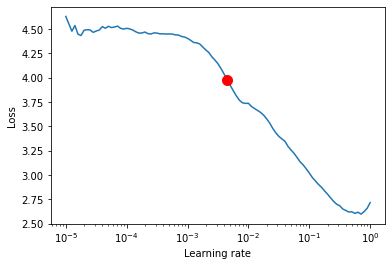

In [9]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [10]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=4e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/tmp/Python/python-3.9.6/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:530: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.851     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  97%|█████████▋| 30/31 [00:20<00:00,  1.49it/s, loss=3.78, v_num=0, train_loss_step=2.330]
Validating: 0it [00:00, ?it/s]
Epoch 1:  97%|█████████▋| 30/31 [00:17<00:00,  1.81it/s, loss=2.06, v_num=0, train_loss_step=1.110, val_loss=2.030, train_loss_epoch=4.250]
Validating: 0it [00:00, ?it/s]
Epoch 2:  97%|█████████▋| 30/31 [00:16<00:00,  1.94it/s, loss=1.46, v_num=0, train_loss_step=0.959, val_loss=0.852, train_loss_epoch=1.630] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  97%|█████████▋| 30/31 [00:15<00:00,  1.97it/s, loss=1.33, v_num=0, train_loss_step=0.950, val_loss=0.803, train_loss_epoch=0.966] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  97%|█████████▋| 30/31 [00:32<00:01,  1.06s/it, loss=1.24, v_num=0, train_loss_step=0.884, val_loss=0.776, train_loss_epoch=0.904]
Validating: 0it [00:00, ?it/s]
Epoch 5:  97%|█████████▋| 30/31 [00:17<00:00,  1.76it/s, loss=1.17, v_num=0, train_loss_step=0.880, val_loss=0.793, train_loss_epoch=0.874] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  9

## Evaluate Results

In [11]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [12]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.1866)

Looking at random samples from the validation set is always a good way to understand if the forecast is reasonable - and it is!

In [13]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

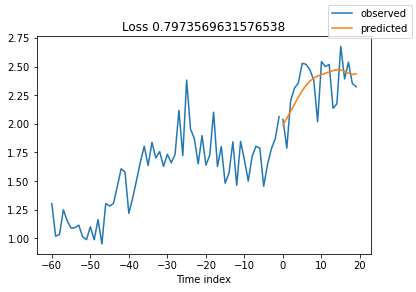

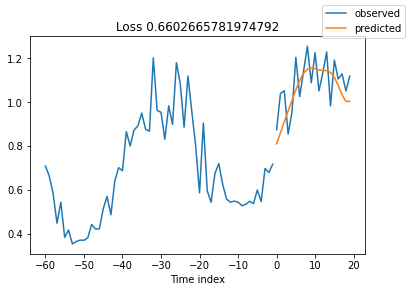

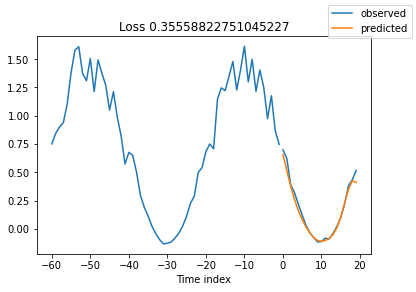

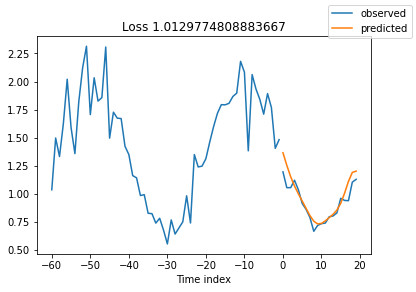

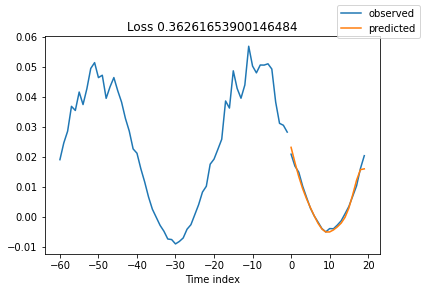

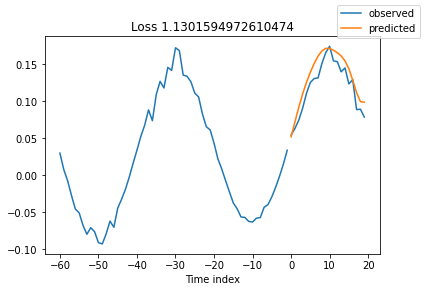

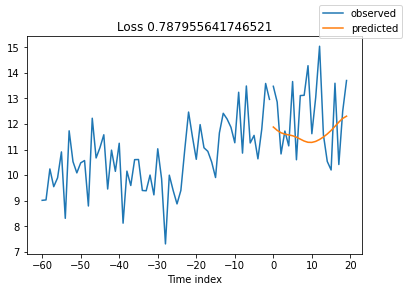

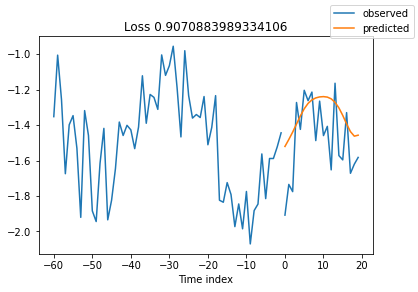

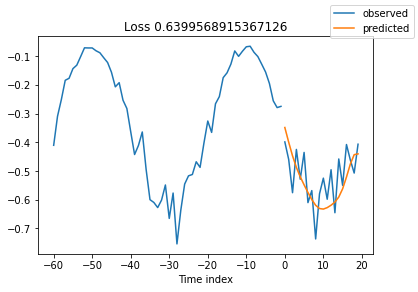

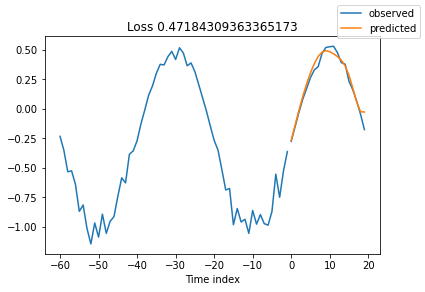

In [14]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

## Interpret model

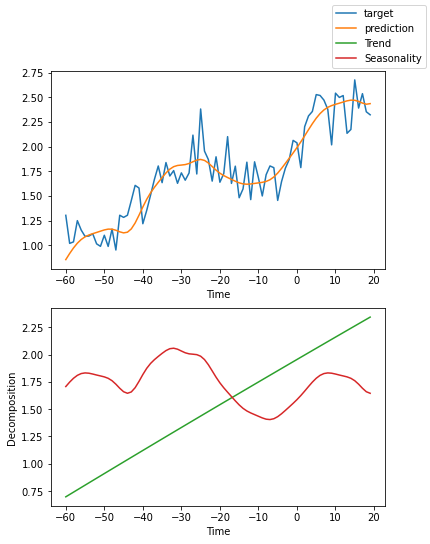

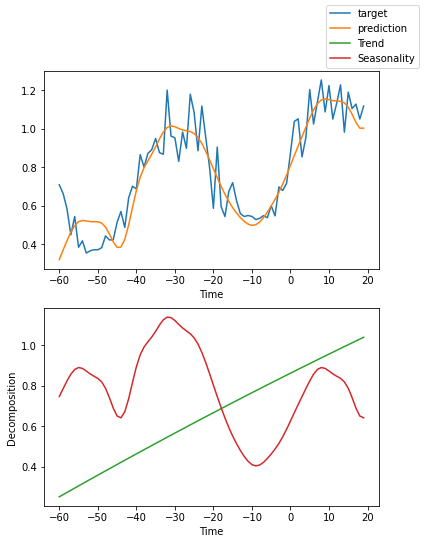

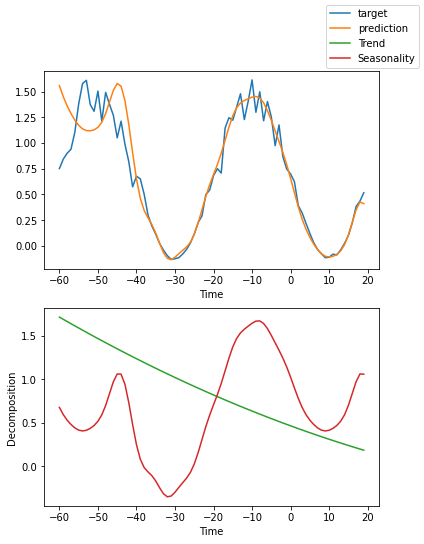

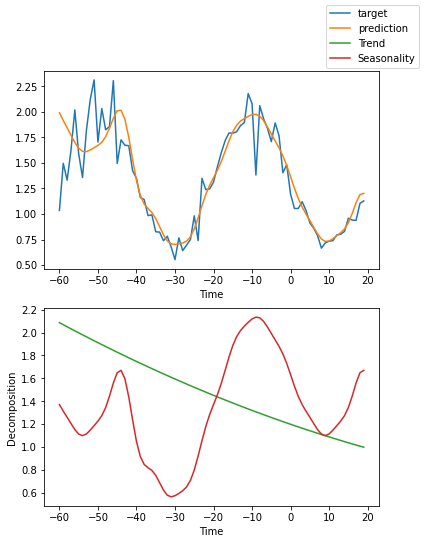

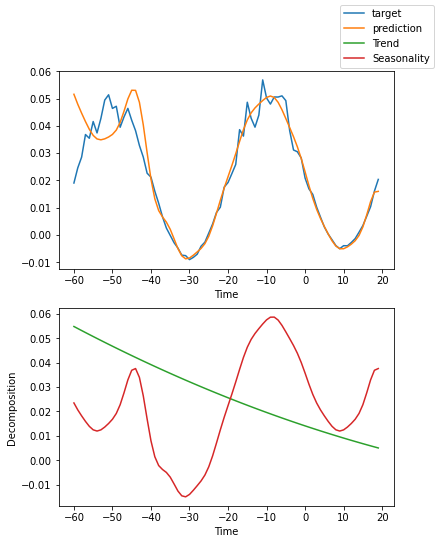

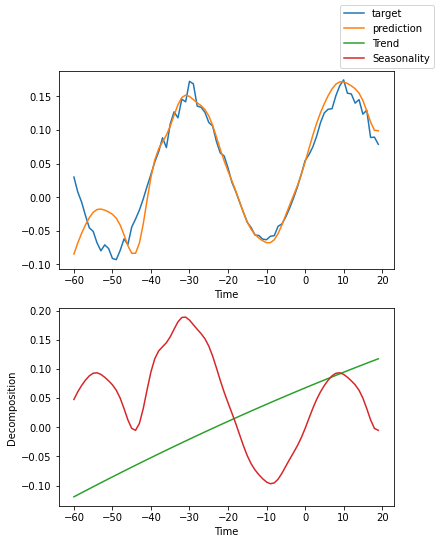

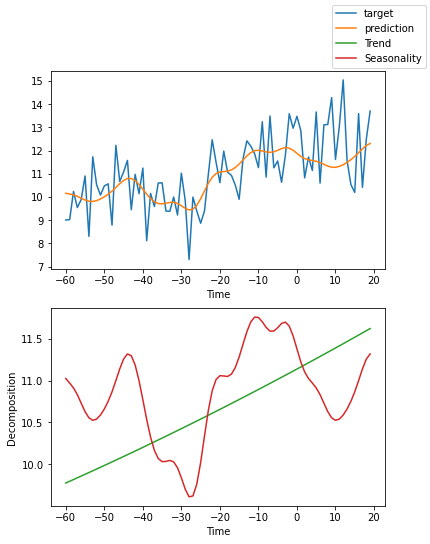

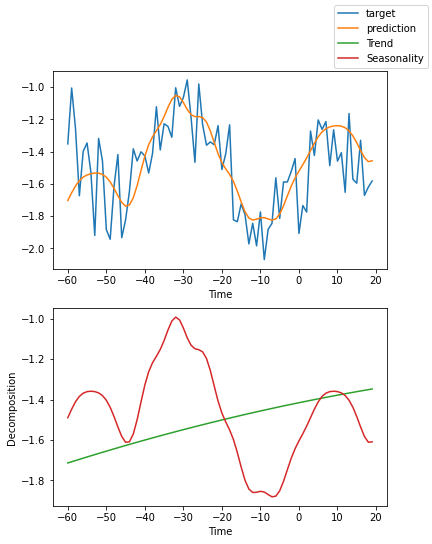

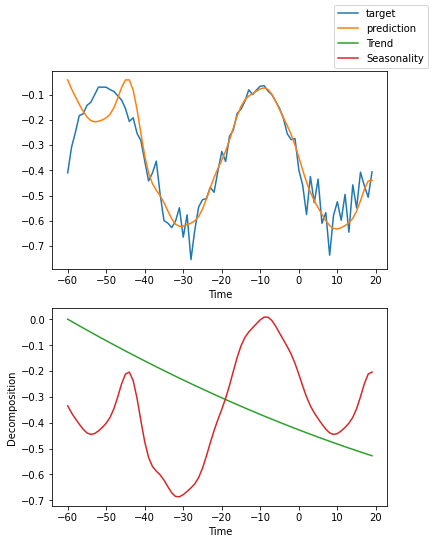

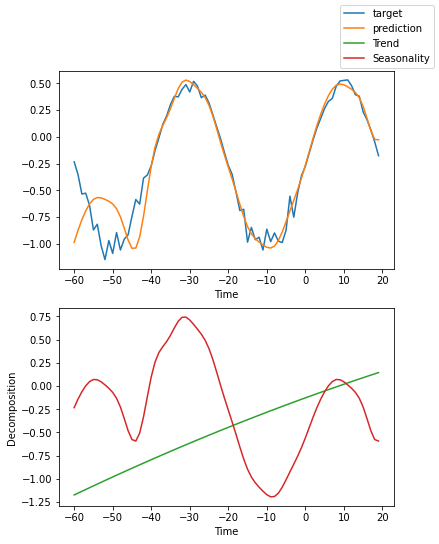

In [15]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx)